In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import os
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [6]:
%cd /content/drive/MyDrive/projects/brain-tumor

/content/drive/MyDrive/projects/brain-tumor


In [171]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)


    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

In [ ]:
smooth = 1e-15

def dice_loss(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1.0 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [ ]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    np.random.seed(42)
    tf.random.set_seed(42)

    create_dir("files")

    """ Hyperparameters """
    batch_size = 8
    lr = 1e-4
    num_epochs = 50
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "log.csv")

    dataset_path = "/content/drive/MyDrive/projects/brain-tumor/dataset"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test : {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=3, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False),
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Train: 1840 - 1840
Valid: 612 - 612
Test : 612 - 612
Epoch 1/50
230/230 [==============================] - ETA: 0s - loss: 0.8035 - dice_coef: 0.1965
Epoch 1: val_loss improved from inf to 0.98134, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 192s 769ms/step - loss: 0.8035 - dice_coef: 0.1965 - val_loss: 0.9813 - val_dice_coef: 0.0186 - lr: 1.0000e-04
Epoch 2/50
230/230 [==============================] - ETA: 0s - loss: 0.6407 - dice_coef: 0.3593
Epoch 2: val_loss improved from 0.98134 to 0.84939, saving model to files/model.h5
230/230 [==============================] - 145s 629ms/step - loss: 0.6407 - dice_coef: 0.3593 - val_loss: 0.8494 - val_dice_coef: 0.1504 - lr: 1.0000e-04
Epoch 3/50
230/230 [==============================] - ETA: 0s - loss: 0.5310 - dice_coef: 0.4690
Epoch 3: val_loss improved from 0.84939 to 0.50188, saving model to files/model.h5
230/230 [==============================] - 138s 598ms/step - loss: 0.5310 - dice_coef: 0.4690 - val_loss: 0.5019 - val_dice_coef: 0.4984 - lr: 1.0000e-04
Epoch 4/50
230/230 [==============================] - ETA: 0s - loss: 0.4469 - dice_coef: 0.5531
Epoch 4: val_loss improved from 0.50188 to 0.47229, saving model to files/model.h

In [7]:

model_path = "/content/drive/MyDrive/projects/brain-tumor/files/model.h5"

model = tf.keras.models.load_model(model_path,
                                   custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})



In [168]:
def perform_inference(img):

  image = cv2.imread(img, cv2.IMREAD_COLOR)
  original_shape = image.shape[:2]
  original_image = image.copy()
  image = cv2.resize(image, (W, H))
  image = image/255.0
  image = np.expand_dims(image, axis=0)

  mask = model.predict(image, verbose=0)[0]
  mask = cv2.resize(mask, (original_shape[1], original_shape[0]))
  mask = mask >= 0.5
  mask = np.expand_dims(mask, axis=-1)
  segmented_image = original_image * mask
  return original_image, mask, segmented_image

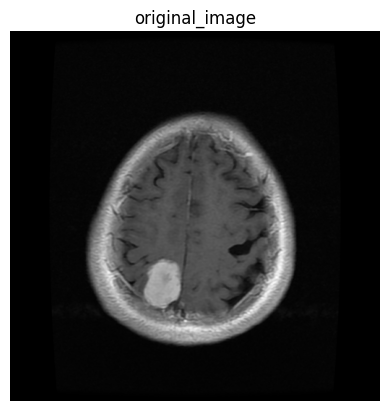

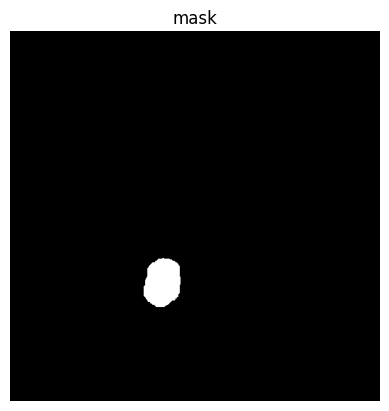

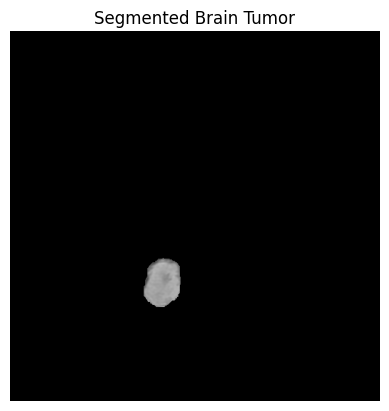

In [170]:
image_path = "/content/drive/MyDrive/projects/brain-tumor/dataset/images/140.png"

def show_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

original_image = perform_inference(image_path)[0]
mask = perform_inference(image_path)[1]
segmented_image = perform_inference(image_path)[2]

show_image(original_image, title="original_image")
show_image(mask, title="mask")
show_image(segmented_image, title="Segmented Brain Tumor")


